### Laboratorium 7 Jak działa GPT?
#### Implemetacja transformera część 2

Imię i nazwisko: ...................

Punktacja:
* 6 pkt. prawidłowa implementacja 
* 2 pkt. wnioski

Rozszerzymy implementację z poprzedniego laboratorium o:
* kodowanie pozycyjne
* warstwę MLP za atencją (co razem daje blok transformera)
* wiele bloków transformera
* strumień resztowy (residual stream)
* normalizację LayerNorm

#### Źródła
* https://youtu.be/kCc8FmEb1nY?si=wYbFi5JB3x-R8375
* https://github.com/karpathy/nanoGPT
* https://arena3-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch

In [2]:
import requests
import torch
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import random

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Przygotowanie danych uczących
* to samo co do tej pory

In [4]:
# jako tekst ponownie wykorzystamy HPMOR rozdziały 1-10
# Eliezer Yudkowsky, Harry Potter and the Methods of Rationality https://hpmor.com/
url = "https://github.com/asztyber/jak_dziala_gpt_lab/blob/main/data/hpmor_chapters_1-10.txt?raw=true"
response = requests.get(url)
text = response.text

In [5]:
len(text)

255326

In [6]:
characters = sorted(set(text))
vocab_size = len(characters)
idx_to_ch = {i: c for i, c in enumerate(characters)}
ch_to_idx = {c: i for i, c in enumerate(characters)}

In [7]:
print(vocab_size)

79


In [8]:
def code(text):
    return [ch_to_idx[c] for c in text]

def decode(tokens):
    return ''.join(idx_to_ch[i] for i in tokens)

In [9]:
text_coded = code(text)
# tensor zawierający dane uczące
train = torch.tensor(text_coded)

In [11]:
def get_batch(data, seq_len=8, batch_size=4):
    '''
    Funkcja zwraca batch danych.
    data (tensor) - dane uczące
    seq_len (int) - długość sekwencji
    batch_size (int) - rozmiar batcha

    X - tensor o kształcie (batch_size, seq_len)
    y - tensor o kształcie (batch_size, seq_len)
    '''
    n = len(data)
    starts = np.random.randint(0, n - seq_len, batch_size)
    X = torch.stack([data[s:s + seq_len] for s in starts])
    y = torch.stack([data[s + 1: s + seq_len + 1] for s in starts])
    return X.to(device), y.to(device)

#### Generacja tekstu

In [12]:
def generate_text(start_seq, model, max_size, seq_len):
    '''
    Funkcja generuje tekst.
    start_seq (str) - początek tekstu, podany przez użytkownika
    model - sieć neuronowa
    max_size (int) - zadana długość tekstu
    seq_len (int) - długość sekwencji podawanej na wejście modelu
    '''
    for i in range(max_size):
        x = code(start_seq[-seq_len:]) #<- zmiana
        logits = model(torch.tensor([x], device=device)) #<- zmiana []
        probs = F.softmax(logits, dim=-1) #<- zmiana dim=-1
        probs = probs[0, -1, :].cpu().detach().numpy() # <- zmiana
        next_ch = idx_to_ch[np.random.choice(vocab_size, p=probs)]
        start_seq += next_ch
    return start_seq

In [21]:
def train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size):
    losses = []
    for step in range(n_steps):
        optimizer.zero_grad()
        x, y = get_batch(train, batch_size=batch_size)
        logits = model(x)
        loss = #TODO (uzupełnić z zeszłego tygodnia)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
        if step % 100 == 0:
            print(f"Krok {step}: Loss = {loss.item():.4f}")
    return losses

### Potrzebne modele z zeszłego tygodnia
* proszę skopiować implementację AttentionHead i MultiHeadAttention

In [15]:
class AttentionHead(nn.Module):
    # TODO

In [16]:
class MultiHeadAttention(nn.Module):
    # TODO

### Kodowanie pozycyjne (Positional embedding)

* uwaga: na wejściu tej warstwy nie ma tokenów, tylko ich numery kolejne

<img src="../../pic/positional_embedding.png" alt="Atencja o wielu głowach" width="500">

### Uzupełnić model o kodowanie pozycyjne
* dodać warstwę kodowania pozycyjnego typu nn.Embedding o wymiarach (*seq_len*, *d_model*)
* kodowanie pozycyjne **dodajemy** do wyniku warstwy emb
* na wejściu warstwy kodowania pozycyjnego podajemy numery kolejne sekwencji tokenów (np. [[0, 1, 2, 3, 4, 5, 6, 7]])
* tensor na wejściu ma kształt (*1*, *seq_len*)
* proszę pamiętać o przeniesieniu tensora wejściowego do warstwy pos_emb na urządzenie device


In [18]:
class MultiHeadModelwithPositionalEmbedding(nn.Module):
    def __init__(self, n_heads, vocab_size, d_head, d_model, seq_len):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model) 
        self.pos_emb =  #TODO
        self.multi_head_attention = MultiHeadAttention(n_heads, d_head, d_model)
        self.linear_out = nn.Linear(d_model, vocab_size)

    def forward(self, X):
        _, seq_len = X.shape # sprawdzamy długość sekwencji w danych wejściowych (model może działać na danych krótszych niż seq_len)
        positional_embedding = #TODO
        x = #TODO
        out = self.multi_head_attention(x)
        logits = self.linear_out(out)
        return logits

In [19]:
batch_size = 256
seq_len = 8
d_model = 16
d_head = 4
n_heads = 4
n_steps = 2000
model = MultiHeadModelwithPositionalEmbedding(n_heads, vocab_size, d_head, d_model, seq_len).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Liczba parametrów modelu: {total_params}')

Liczba parametrów modelu: 3759


In [22]:
losses = train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size)

Krok 0: Loss = 4.4585
Krok 100: Loss = 2.9498
Krok 200: Loss = 2.8301
Krok 300: Loss = 2.6732
Krok 400: Loss = 2.6031
Krok 500: Loss = 2.5596
Krok 600: Loss = 2.5466
Krok 700: Loss = 2.5687
Krok 800: Loss = 2.4967
Krok 900: Loss = 2.5036
Krok 1000: Loss = 2.4813
Krok 1100: Loss = 2.4711
Krok 1200: Loss = 2.4297
Krok 1300: Loss = 2.4223
Krok 1400: Loss = 2.4563
Krok 1500: Loss = 2.4055
Krok 1600: Loss = 2.4204
Krok 1700: Loss = 2.4084
Krok 1800: Loss = 2.4228
Krok 1900: Loss = 2.3284


In [23]:
generate_text('T', model, 100, seq_len)

'Thes\nfoush rentgess thonfle Aa thae boionkd besg wominde\ndoullkoud, busl whe dor the hive irsrer assm'

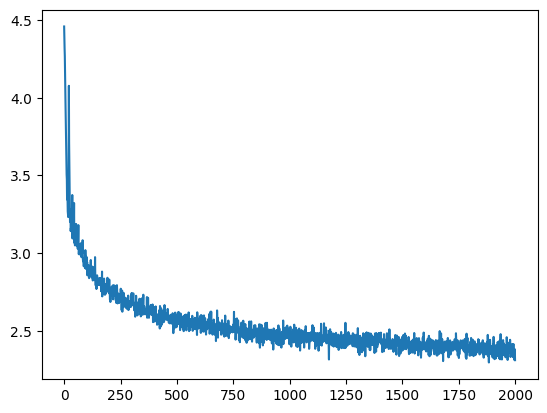

In [24]:
plt.plot(losses);

### Transformer
* tworzymy **TransformerBlock** dodając za atencją:
    * warstwę liniową *d_model* x 4*d_model*
    * funkcję aktywacji GELU
    * warstwę liniową 4*d_model* x *d_model*

<img src="../../pic/transformer_block.png" alt="Transformer" width="400">

### Zaimplementować klasę MLPBlock
* warstwa liniowa *d_model* x 4*d_model*
* funkcja aktywacji GELU
* warstwa liniowa 4*d_model* x *d_model*


In [26]:
class MLPBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear1 = #TODO
        self.gelu = #TODO
        self.linear2 = #TODO

    def forward(self, x):
        #TODO
        return x 

### Zaimplementować klasę TransformerBlock
* warstwa MultiHeadAttention
* warstwa MLPBlock

In [27]:
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, d_head, d_model):
        super().__init__()
        self.multi_head_attention = #TODO
        self.mlp = #TODO

    def forward(self, x):
        #TODO
        return x

### Zaimplementować model z jedną warstwą TransformerBlock - TransformerOneLayerModel
* warstwa embedding
* warstwa kodowania pozycyjnego
* warstwa liniowa *d_model* x *vocab_size*
* warstwa TransformerBlock
* **jedyna różnica w porównaniu do MultiHeadModelwithPositionalEmbedding to zamiana MultiHeadAttention przez TransformerBlock**


In [28]:

class TransformerOneLayerModel(nn.Module):
    def __init__(self, n_heads, vocab_size, d_head, d_model, seq_len):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model) 
        self.pos_emb = #TODO
        self.transformer_block =  #TODO
        self.linear_out = nn.Linear(d_model, vocab_size) 

    def forward(self, X):
        _, seq_len = X.shape
        x = #TODO
        out = #TODO
        logits = self.linear_out(out)
        return logits

In [29]:
batch_size = 256
seq_len = 8
d_model = 16
d_head = 4
n_heads = 4
n_steps = 2000
model = TransformerOneLayerModel(n_heads, vocab_size, d_head, d_model, seq_len).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Liczba parametrów modelu: {total_params}')

Liczba parametrów modelu: 5887


In [31]:
losses = train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size)

Krok 0: Loss = 4.3984
Krok 100: Loss = 3.0965
Krok 200: Loss = 2.8782
Krok 300: Loss = 2.7810
Krok 400: Loss = 2.7252
Krok 500: Loss = 2.5413
Krok 600: Loss = 2.4927
Krok 700: Loss = 2.4563
Krok 800: Loss = 2.4377
Krok 900: Loss = 2.3293
Krok 1000: Loss = 2.3850
Krok 1100: Loss = 2.3559
Krok 1200: Loss = 2.3379
Krok 1300: Loss = 2.2841
Krok 1400: Loss = 2.2834
Krok 1500: Loss = 2.3342
Krok 1600: Loss = 2.2693
Krok 1700: Loss = 2.2286
Krok 1800: Loss = 2.2931
Krok 1900: Loss = 2.2132


In [32]:
generate_text('T', model, 100, seq_len)

"That yin. I he to Dain fchat fan known't giment allof saw sHard junge to the aphectt do ovestt cos wo"

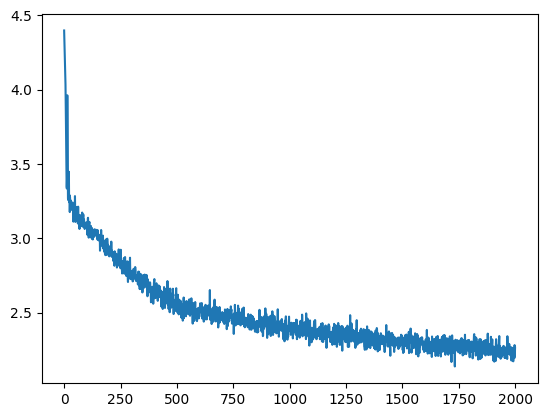

In [33]:
plt.plot(losses);

### Wiele warstw - zaimplementować model TransformerModel
* dodać 3 warstwy TransformerBlock po sobie
* wykorzystać nn.Sequential

In [34]:
# transformer blocks zamiast transformer block
class TransformerModel(nn.Module):
    def __init__(self, n_heads, vocab_size, d_head, d_model, seq_len):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model) 
        self.pos_emb = #TODO
        self.transformer_blocks = #TODO
        self.linear_out = nn.Linear(d_model, vocab_size)

    def forward(self, X):
        _, seq_len = X.shape
        x = #TODO
        out = #TODO
        logits = self.linear_out(out)
        return logits

In [35]:
batch_size = 256
seq_len = 8
d_model = 16
d_head = 4
n_heads = 4
n_steps = 2000
model = TransformerModel(n_heads, vocab_size, d_head, d_model, seq_len).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Liczba parametrów modelu: {total_params}')

Liczba parametrów modelu: 12191


In [37]:
losses = train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size)

Krok 0: Loss = 4.3891
Krok 100: Loss = 3.0232
Krok 200: Loss = 2.9524
Krok 300: Loss = 2.7424
Krok 400: Loss = 2.5305
Krok 500: Loss = 2.4755
Krok 600: Loss = 2.3793
Krok 700: Loss = 2.3056
Krok 800: Loss = 2.2896
Krok 900: Loss = 2.3208
Krok 1000: Loss = 2.2141
Krok 1100: Loss = 2.1888
Krok 1200: Loss = 2.2100
Krok 1300: Loss = 2.2084
Krok 1400: Loss = 2.1004
Krok 1500: Loss = 2.1177
Krok 1600: Loss = 2.1024
Krok 1700: Loss = 2.1441
Krok 1800: Loss = 2.0492
Krok 1900: Loss = 2.1335


In [38]:
generate_text('T', model, 100, seq_len)

'This or ising likasteded. "Al pak a luiso he bagce, some betterhten he frid otn bestice her?"\nShey se'

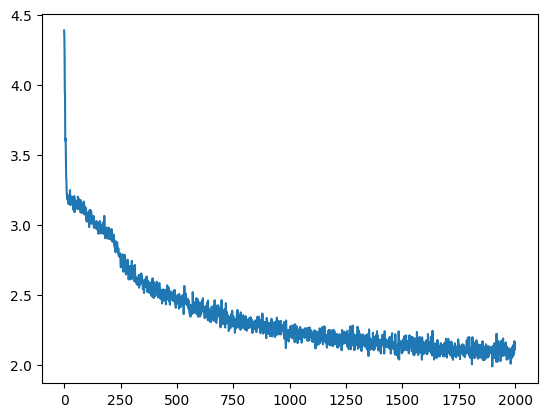

In [39]:
plt.plot(losses);

### Residual stream
* zmodyfikować transformer block, tak, żeby zawierał residual stream
* $+$ na schemacie oznacza zwykłe dodawanie

<img src="../../pic/residual_stream.png" alt="Residual stream" width="400">

#### Zmodyfikować TransformerBlock
* dodać residual stream

In [40]:
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, d_head, d_model):
        super().__init__()
        self.multi_head_attention = #TODO
        self.mlp = #TODO
        
    def forward(self, x):
        x = #TODO
        x = #TODO
        return x

In [41]:
batch_size = 256
seq_len = 8
d_model = 16
d_head = 4
n_heads = 4
n_steps = 2000
model = TransformerModel(n_heads, vocab_size, d_head, d_model, seq_len).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [42]:
losses = train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size)

Krok 0: Loss = 4.9478
Krok 100: Loss = 2.4613
Krok 200: Loss = 2.2696
Krok 300: Loss = 2.1855
Krok 400: Loss = 2.0913
Krok 500: Loss = 2.0647
Krok 600: Loss = 2.0974
Krok 700: Loss = 2.0774
Krok 800: Loss = 2.0683
Krok 900: Loss = 2.0089
Krok 1000: Loss = 2.0011
Krok 1100: Loss = 1.9841
Krok 1200: Loss = 1.9946
Krok 1300: Loss = 2.0134
Krok 1400: Loss = 1.9144
Krok 1500: Loss = 2.0277
Krok 1600: Loss = 1.9599
Krok 1700: Loss = 2.0054
Krok 1800: Loss = 1.9871
Krok 1900: Loss = 1.9506


In [43]:
generate_text('T', model, 100, seq_len)

"That theat! In about hugle my, evend in\nProfessor Mitorged at for kard int\npary. I quen't alince? If "

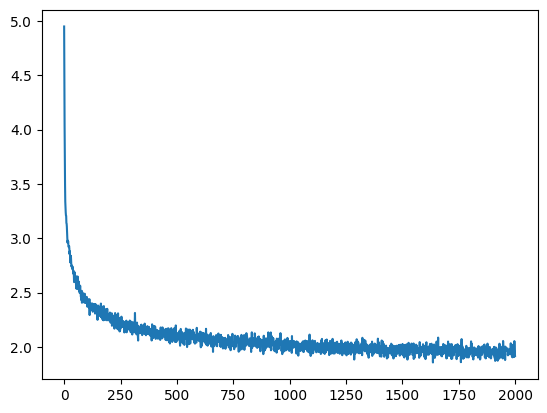

In [44]:
plt.plot(losses);

### Layer norm
* uzupełnić Transformer Block o dwie warstwy Layer Norm

<img src="../../pic/layer_norm.png" alt="Layer norm" width="300">

#### Zmodyfikować TransformerBlock
* dodać dwie warstwy Layer Norm w miejscach według schematu (nn.LayerNorm)
* do konstruktora warstwy LayerNorm podajemy rozmiar wymiaru, dla którego ma być zastosowana normalizacja (*d_model*)

In [46]:
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, d_head, d_model):
        super().__init__()
        self.multi_head_attention = #TODO
        self.mlp = #TODO
        self.ln1 = #TODO
        self.ln2 = #TODO
        
    def forward(self, x):
        #TODO
        return x

In [47]:
batch_size = 256
seq_len = 8
d_model = 16
d_head = 4
n_heads = 4
n_steps = 2000
model = TransformerModel(n_heads, vocab_size, d_head, d_model, seq_len).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [48]:
losses = train_loop(model, optimizer, n_steps, batch_size, seq_len, vocab_size)

Krok 0: Loss = 4.6496
Krok 100: Loss = 2.5341
Krok 200: Loss = 2.3139
Krok 300: Loss = 2.1518
Krok 400: Loss = 2.1473
Krok 500: Loss = 2.1197
Krok 600: Loss = 2.1480
Krok 700: Loss = 2.0977
Krok 800: Loss = 2.0092
Krok 900: Loss = 2.0123
Krok 1000: Loss = 2.0078
Krok 1100: Loss = 1.9473
Krok 1200: Loss = 1.9585
Krok 1300: Loss = 2.0315
Krok 1400: Loss = 1.9784
Krok 1500: Loss = 2.0153
Krok 1600: Loss = 1.9464
Krok 1700: Loss = 2.0108
Krok 1800: Loss = 1.9981
Krok 1900: Loss = 2.0148


In [49]:
generate_text('T', model, 100, seq_len)

"Tera lotked lanoys whatged a swich a velply up at pein\ndull somether works\nyou hade in of Insmeth 'st"

### Wnioski
1. Czy modele będą działać dla danych wejściowych dłuższych niż seq_len? Dlaczego? *Uwaga: w funkcji generate_text dane wejściowe są zawsze przycinane do seq_len*
2. Porównaj wszystkie modele pod względem jakości tekstu, wartości funkcji straty i liczby parametrów
3. (dla chętnych) Można eksperymentować z batch_size, seq_len, d_model, d_head, n_heads, n_steps, lr i liczbą warstw. Jaki najlepszy model udało się uzyskać?

### Dalsze możliwości rozwoju
1. Wykorzystanie danych walidacyjnych (np. kolejnego rozdziału), aby sprawdzić, czy model się nie przeucza
2. Zapis i odczyt checkpointów
3. Zmniejszanie współczynnika uczenia w kolejnych krokach (learning rate decay)
4. Więcej warstw, większe wymiary modelu
5. Większy słownik (tokenizacja!)
6. Obecnie każda głowa jest liczona osobo i wyniki są konkatenowane (a następnie sumowane). Dla wydajności można dodać liczbę głów jako czwarty wymiar. To podjeście jest równoważne matematycznie, jest wydajniejszą implementacją, ale jest trudnejsze do zrozumienia.